
# Hands-on Exercise 3: Distributed RL training with Amazon SageMaker and AWS RoboMaker for the AWS DeepRacer

---
## Overview

Okay, so now your environment is set up with the AWS CloudFormation template and you have initialized the notebook. For the rest of this exercise, you'll get hands-on experience with Amazon SageMaker and AWS RoboMaker so that you can better understand how they power the AWS DeepRacer.

Unlike the first two exercises in this course that had you building, training, and evaluating your models via the console UI, this exercise encourages you to get under the hood of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome). You'll go through the build, train, and evaluate process by interacting directly with Amazon SageMaker and AWS RoboMaker. In doing so, you will gain more control over the model training, tuning, and simulation process.

![Training in Action](./deepracer-hard-track-world.jpg)

---
## How it works  

![How training works](./training.png)

The RL agent (that is, your autonomous car) learns to drive by interacting with its environment (the track) and by taking actions in a given state to maximize the expected rewards. During training, the agent learns what optimal actions are by trial and error, through repeated episodes.  

The figure above shows a distributed RL training across Amazon SageMaker and two AWS RoboMaker simulation environments. This distributed RL training performs the **rollouts**, which execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with Amazon SageMaker for training. Amazon SageMaker then updates the model policy, which is used to execute the next sequence of rollouts. This training loop continues until the model converges--that is, until the car learns to drive and stops going off the track. More formally, you can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker
3. **State**: The driving point of view (POV) image captured by the car's head camera, as shown above
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; high penalty for going off-track. This is configurable and can be made more complex (for example, by adding a steering penalty)



# Setting up the development environment

### Imports

To get started, you will import the Python libraries you need, and set up the environment with a few prerequisites for permissions and configurations.

In [2]:
import sagemaker
import json
import boto3
import sys
import urllib.request
import os
import glob
import re
import subprocess
from IPython.display import Markdown
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from markdown_helper import *
from botocore.exceptions import UnknownServiceError
import pandas as pd
from io import StringIO

You will use Boto to call to different services in your AWS account. Running the code block below will set this up and collect the credentials that are currently being passed to your Amazon SageMaker instance to sign any calls you have to make later in this notebook. When this notebook was written, the services used in this exercise (Amazon SageMaker, AWS RoboMaker) have not been deployed to all AWS Regions. A check will be made to ensure that the AWS CloudFormation template to build the base of this exercise has been run inside a supported region. 

In [3]:
sage_session = sagemaker.session.Session()
aws_region = sage_session.boto_region_name
robomaker = boto3.client("robomaker")

s3 = boto3.client('s3')
role = sagemaker.get_execution_role()
roleSplit = role.split(':')
accountID = roleSplit[4]

if aws_region not in ["us-east-1"]:
    raise Exception("This Notebook needs to be running in AWS Region US-East-1 (N. Virginia). Deploy your AWS cloudformation stack in that region")

## Training a new model or retraining an existing one

By default, this notebook will create a new model from scratch. However, you do have the ability to retrain a model you've used before (you might want to consider the model you used in earlier course exercises). To do this, you need to set the bool `retrain` flag below to `0` for a new model or `1` for retraining an old model.

If you are retraining an old model, you will have to provide the checkpoint files that were used during the original training. These files can be found in the AWS DeepRacer S3 bucket created by your AWS CloudFormation stack. They follow the naming format `deepracer-trainingexercise` followed by the AWS Region you used and your 12-digit account number.

You will find these data files, indexes, and metadata files in the `model` folder in the corresponding jobs prefix. If your model was originally trained via this notebook on 03/21/19-20:03, for instance, you would find those files at directory `/rl-deepracer-sagemaker-19-03-21--20-03/model`.

In [4]:
retrain = bool(0)

# Define timestamp once, to ensure unique name, but have consistent job names to tie jobs together
timestamp = strftime("%y-%m-%d--%H-%M", gmtime())
job_name_prefix = 'rl-deepracer'
# TODO apend hyphen to prefex
# job_name_prefix = 'rl-deepracer-'
pretrainModelDesc = "Default-"

# Duration of job in seconds (2 hours)
job_duration_in_seconds = 3600 * 2

if retrain == False: # Training a new model 
    # S3 bucket
    s3_bucket = 'deepracer-trainingexercise-' + aws_region + '-' + accountID 
    s3_prefix = job_name = job_name_prefix + "sagemaker-" + timestamp
    s3_prefix_robomaker = job_name_prefix + "robomaker-" + timestamp
    
    pretrained_s3_bucket = None
    pretrained_s3_prefix = None

if retrain == True: # Retraining an old model 
    
    pretrained_s3_bucket = 'deepracer-trainingexercise-' + aws_region + '-' + accountID
    pretrained_s3_prefix = 'retrainmodel/' # Don't need to include the 'model/' folder in the prefix
    
    job_name = job_name_prefix +'-'+ pretrainModelDesc + "retrain-" + timestamp
    s3_bucket = 'deepracer-trainingexercise-' + aws_region + '-' + accountID
    s3_prefix = job_name_prefix +'-'+ pretrainModelDesc + "sagemaker-retrain-" + timestamp
    s3_prefix_robomaker = job_name_prefix +'-'+ pretrainModelDesc + "robomaker-retrain-" + timestamp
    
s3_output_path = 's3://{}/'.format(s3_bucket) # SDK appends the job name and output folder

print('Model checkpoints and other metadata will be stored at: ' + s3_output_path + job_name)
print("RoboMaker logging will be stored at : {}{}".format(s3_output_path, s3_prefix_robomaker))

Model checkpoints and other metadata will be stored at: s3://deepracer-trainingexercise-us-east-1-576690301298/rl-deepracersagemaker-19-06-25--09-31
RoboMaker logging will be stored at : s3://deepracer-trainingexercise-us-east-1-576690301298/rl-deepracerrobomaker-19-06-25--09-31


### Configuring the VPC

Since Amazon SageMaker and AWS RoboMaker have to communicate with each other over the network, they both need to run in VPC mode. The AWS CloudFormation template you launched built the networking layer that supports these services. However, this notebook needs to discover what VPC ID it is running in and the subnet where AWS Robomaker and Amazon SageMaker can create instances. To support these node-to-node communications, a security group will need to be attached. 

Running the code block below allows this notebook to discover these resource IDs and load them into memory.

This notebook is programmed to look for a VPC with a IP block range of 10.96.0.0/16. If you changed the default AWS CloudFormation stack parameters at stack creation, this code block may fail to run. Make sure the IP block range matches the IP block range of 10.96.0.0/16. 


In [5]:
ec2 = boto3.client('ec2')

default_vpc = [vpc['VpcId'] for vpc in ec2.describe_vpcs()['Vpcs'] if vpc["CidrBlock"] == '10.96.0.0/16'][0] 

default_security_groups = [group["GroupId"] for group in ec2.describe_security_groups()['SecurityGroups'] \
                   if group["GroupName"] == "default" and group["VpcId"] == default_vpc]

default_subnets = [subnet["SubnetId"] for subnet in ec2.describe_subnets()["Subnets"] \
                  if subnet["VpcId"] == default_vpc and subnet['MapPublicIpOnLaunch']==False]

print("Using VPC:", default_vpc)
print("Using security group:", default_security_groups)
print("Using subnets:", default_subnets)

Using VPC: vpc-07c48fed79cdeb9b8
Using security group: ['sg-0ac42b58e5380e6c3']
Using subnets: ['subnet-06b6c4ee99f473cc4', 'subnet-076543dbc741fae50', 'subnet-0e5ad60a5e086d4b7', 'subnet-0dcba498d58079685']


## Navigating the configurations  


By running these simulations via Amazon SageMaker, you gain greater control over the settings in the simulated environment and the data being collected. Let's discuss some of these files and the role they play in helping with model learning by rewarding good driving

###  The reward function

The environment is defined in a Python file called “deepracer_env.py,” which can be found at `src/robomaker/environments/`. This file implements the gym interface for your Gazebo-based AWS RoboMaker simulator. This is a common environment file used by both Amazon SageMaker and AWS RoboMaker. The environment variable - `NODE_TYPE` defines which node the code is running on. So the expressions that have `rospy` dependencies are executed on AWS RoboMaker only.  

You can experiment with different reward functions by modifying `reward_function` in this file. You can also change the action space and steering angles by modifying the step method in `DeepRacerDiscreteEnv` class.


In [6]:
!pygmentize src/robomaker/environments/deepracer_env.py

from __future__ import print_function

import time

# only needed for fake driver setup
import boto3
# gym
import gym
import numpy as np
from gym import spaces
from PIL import Image
import os
import math

# Type of worker
SIMULATION_WORKER = "SIMULATION_WORKER"
SAGEMAKER_TRAINING_WORKER = "SAGEMAKER_TRAINING_WORKER"

node_type = os.environ.get("NODE_TYPE", SIMULATION_WORKER)

if node_type == SIMULATION_WORKER:
    import rospy
    from ackermann_msgs.msg import AckermannDriveStamped
    from gazebo_msgs.msg import ModelState
    from gazebo_msgs.srv import SetModelState

    from sensor_msgs.msg import Image as sensor_image
    from deepracer_msgs.msg import Progress

TRAINING_IMAGE_SIZE = (160, 120)
FINISH_LINE = 100

# REWARD ENUM
CRASHED = 0
NO_PROGRESS = -1
FINISHED = 10000000.0
MAX_STEPS = 1000000

# WORLD NAME
EASY_TRACK_WORLD = 'easy_track'
MEDIUM_TRACK_WORLD = 'medium_track'
HARD_TRACK_WORLD = 'hard_track'

# SLEEP INTERVALS
SLEEP_AFTER_RESET_TIME_IN_SECOND = 0.5
SLEEP_BETWEEN_

### Hyperparameters

One way to improve your model's performance is to enact a better or more effective training process. For example, to develop a robust model, training must provide your agent more or less evenly distributed sampling over the agent's action space. This requires a sufficient mix of explorations and exploitations. The variables that affect this include the amount of training data used (number of episodes between each training and batch size), how fast the agent can learn (learning rate), and the portion of exploration (entropy). To make training practical, you may want to experiment with speeding up the learning process. The variables that affect this include learning rate, batch size, number of epochs, and discount factor.

The variables affecting the training process are known as *hyperparameters*. They're algorithm attributes that are not properties of the underlying model. Unfortunately, hyperparameters are empirical in nature. Their optimal values are not known *a priori* for all practical purposes and require systematic experimentation through iterations.


In [7]:
!pygmentize src/robomaker/presets/deepracer.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.base_parameters import VisualizationParameters, PresetValidationParameters
from rl_coach.core_types import TrainingSteps, EnvironmentEpisodes, EnvironmentSteps, RunPhase
from rl_coach.environments.gym_environment import GymVectorEnvironment
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.schedules import LinearSchedule

from rl_coach.exploration_policies.categorical import CategoricalParameters
from rl_coach.filters.filter import NoInputFilter, NoOutputFilter, InputFilter
from rl_coach.filters.observation.observation_stacking_filter import ObservationStackingFilter
from rl_coach.filters.observation.observation_rgb_to_y_filter import ObservationRGBToYFilter
from rl_coach.filters.observation.observation_to_uint8_filter import ObservationToUInt8Filter
from rl_coach.memories.memory import Memo

### Training entry point

The training code is written in the file `training_worker.py`, which is uploaded in the `/src` directory. This is the code that is being used to start a Redis server that will receive agent experiences by rollout training worker[s]. After receiving these agent experiences, `training_worker.py` will trigger model training after a defined number of episodes are received. After the training cycle has finished, it will upload the new model weights to the defined S3 bucket, and notify the workers to update their models and execute the next set of episodes.

In [8]:
!pygmentize src/training_worker.py

import argparse
import json
import logging
import os
import time
import subprocess

from markov.s3_client import SageS3Client
from markov.utils import get_ip_from_host, DoorMan
from markov.s3_boto_data_store import S3BotoDataStore, S3BotoDataStoreParameters
from rl_coach import core_types
from rl_coach.base_parameters import TaskParameters, DistributedCoachSynchronizationType, Frameworks
from rl_coach.logger import screen
from rl_coach.memories.backend.redis import RedisPubSubMemoryBackendParameters
from rl_coach.utils import short_dynamic_import

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.DEBUG)

logger = logging.getLogger(__name__)

PRETRAINED_MODEL_DIR = "./pretrained_checkpoint"
INTERMEDIATE_FOLDER = "/opt/ml/output/intermediate/"


def training_worker(graph_manager, checkpoint_dir, use_pretrained_model, framework):
    """
    restore a checkpoint then perform rollouts using the restored model
    """
    # initialize graph
    task_parameters = TaskParameters()
 

### Uploading configurations to Amazon S3

Upload `src/robomaker/presets/deepracer.py` and `src/robomaker/environments/deepracer_env.py` to `s3_bucket` `s3_prefix`. These files must be present when the Amazon SageMaker training job is created. 

In [9]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)

# Make any changes to the envrironment and preset files below and upload these files
!aws s3 cp src/robomaker/environments/ {s3_location}/environments/ --recursive --exclude ".ipynb_checkpoints*" --exclude "*.pyc"
!aws s3 cp src/robomaker/presets/ {s3_location}/presets/ --recursive --exclude ".ipynb_checkpoints*" --exclude "*.pyc"

upload: src/robomaker/environments/deepracer_env.py to s3://deepracer-trainingexercise-us-east-1-576690301298/rl-deepracersagemaker-19-06-25--09-31/environments/deepracer_env.py
upload: src/robomaker/environments/__init__.py to s3://deepracer-trainingexercise-us-east-1-576690301298/rl-deepracersagemaker-19-06-25--09-31/environments/__init__.py
upload: src/robomaker/presets/__init__.py to s3://deepracer-trainingexercise-us-east-1-576690301298/rl-deepracersagemaker-19-06-25--09-31/presets/__init__.py
upload: src/robomaker/presets/deepracer.py to s3://deepracer-trainingexercise-us-east-1-576690301298/rl-deepracersagemaker-19-06-25--09-31/presets/deepracer.py


## RLEstimator for training RL jobs

To set up your training environment, you will call the class RLEstimator. This estimator executes an RLEstimator script in a managed RL execution environment within an Amazon SageMaker training job. The managed RL environment is an Amazon-built Docker container that executes functions defined in the supplied entry_point Python script.

[RLEstimator Doc](https://sagemaker.readthedocs.io/en/stable/sagemaker.rl.html)

When calling this class, we can define:
1. Source directory, which has the environment file, preset and training code
2. Entry point as the training code
3. Specify the RL toolkit and framework used. This then will apply to the RL container
4. Define the RLCOACH preset of `deepracer` 
5. Training parameters
  - instance count - **Only 1 training instance is supported for now**
  - instance type  - Default to ml.c4.2xlarge
  - job name 
  - s3_bucket - Bucket to store training data
  - s3_prefix - Prefix to store model checkpoint and metadata 
  - pretrained_s3_bucket - S3 Bucket where a prior model is saved. Only needed if retraining
  - pretrained_s3_prefix - The path to where the file is saved. Only needed if retraining
6.  Metrics that you want to capture from Amazon CloudWatch logs to monitor the training process. 
    
Training is not started until you call the fit()
    
Below are algorithm-specific parameters which might change for different algorithms. In this example, we use [ClippedPPO](https://coach.nervanasys.com/algorithms/policy_optimization/cppo/index.html). This data could be sent to Amazon CloudWatch or Amazon SageMaker Notebooks for visualization.

In [10]:
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {'Name': 'reward-training',
     'Regex': '^Training>.*Total reward=(.*?),'},
    
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {'Name': 'ppo-surrogate-loss',
     'Regex': '^Policy training>.*Surrogate loss=(.*?),'},
     {'Name': 'ppo-entropy',
     'Regex': '^Policy training>.*Entropy=(.*?),'},
   
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {'Name': 'reward-testing',
     'Regex': '^Testing>.*Total reward=(.*?),'},
]

In [11]:
RLCOACH_PRESET = "deepracer"
instance_type = "ml.c4.2xlarge"

print('S3 Logging Bucket: ' + s3_bucket)
print('S3 Logging Prefix: ' + s3_prefix)

#if retrain == True:
print('Pretrained Model Bucket: ' + str(pretrained_s3_bucket))
print('Pretrained Model Prefix: ' + str(pretrained_s3_bucket))
estimator = RLEstimator(entry_point="training_worker.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        train_max_run=job_duration_in_seconds, # Maximum runtime in seconds
                        hyperparameters={"pretrained_s3_bucket": pretrained_s3_bucket,
                                         "pretrained_s3_prefix": pretrained_s3_prefix,
                                         "s3_bucket": s3_bucket,
                                         "s3_prefix": s3_prefix,
                                         "aws_region": aws_region, 
                                         "RLCOACH_PRESET": RLCOACH_PRESET,
                                      },
                        metric_definitions = metric_definitions,
                        subnets=default_subnets, # Required for VPC mode
                        security_group_ids=default_security_groups, # Required for VPC mode
                    )
estimator.fit(job_name=job_name, wait=False, logs=False )

S3 Logging Bucket: deepracer-trainingexercise-us-east-1-576690301298
S3 Logging Prefix: rl-deepracersagemaker-19-06-25--09-31
Pretrained Model Bucket: None
Pretrained Model Prefix: None


# Setting up AWS Robomaker

### Creating the simulation environment 

For this exercise, AWS RoboMaker will need a package containing the simulation environment. Below, you will download a package created by the AWS RoboMaker product team. 

This file is big, and it is not going to change frequently. So rather than downloading it each time you train a model, just check if that file is there. If you want to update this file, you can simply rename it or delete it from your S3 bucket. 

In [12]:
simulation_application_bundle_location = "https://s3.amazonaws.com/deepracer-managed-resources/deepracer-github-simapp.tar.gz"


bundle_s3_key = 'deepracer/simulation_ws.tar.gz'

result = s3.list_objects(Bucket=s3_bucket,Prefix=bundle_s3_key)
if 'Contents' not in result:
    print('Deepracer application simulation bundle not found... Downloading it now')
    !wget {simulation_application_bundle_location}
    print('Uploading simulation bundle to S3.')
    !aws s3 cp deepracer-github-simapp.tar.gz s3://{s3_bucket}/{bundle_s3_key}
else:
    print('Deepracer application simulation bundle found at:')
    print('s3://'+s3_bucket+'/'+bundle_s3_key)
    print('Delete or rename this file in s3 to download a new source from deepracer team')

Deepracer application simulation bundle found at:
s3://deepracer-trainingexercise-us-east-1-576690301298/deepracer/simulation_ws.tar.gz
Delete or rename this file in s3 to download a new source from deepracer team


Now upload this to AWS RoboMaker as a simulation application.

In [13]:
app_name = "deepracerSagemakerSimulation-" + timestamp

bundle_s3_key = 'deepracer/simulation_ws.tar.gz'
bundle_source = {'s3Bucket': s3_bucket,
                 's3Key': bundle_s3_key,
                 'architecture': "X86_64"}
simulation_software_suite={'name': 'Gazebo',
                           'version': '7'}
robot_software_suite={'name': 'ROS',
                      'version': 'Kinetic'}
rendering_engine={'name': 'OGRE', 'version': '1.x'}

try:
    response = robomaker.create_simulation_application(name=app_name,
                                                   sources=[bundle_source],
                                                   simulationSoftwareSuite=simulation_software_suite,
                                                   robotSoftwareSuite=robot_software_suite,
                                                   renderingEngine=rendering_engine
                                                  )
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:576690301298:simulation-application/deepracerSagemakerSimulation-19-06-25--09-31/1561455125677


### Launch the simulation job on AWS RoboMaker

Before launching the simulation job on AWS RoboMaker, first make sure that all your defined parameters are correct for your testing scenario. This simulation can take several minutes to load, and it's billed by the hour--so make sure everything is correct before you begin.

`World_NAME` is name of the world or track that you will load into AWS RoboMaker. 

1. `"easy_track"` - Drag race, long straight roadway with a center line down the middle 
2. `"medium_track"` - A big O, with four left turns to make a big loop
3. `"hard_track"` - A more complex track that has two long straightaways, as well as a double left turn and a single right turn

TODO be sure to discuss this track option limitation

Create [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) simulation jobs to simulate the environment and share this data with Amazon SageMaker for training. 

In [26]:
# Use more rollout workers for faster convergence
num_simulation_workers = 1
sim_failure_behavior = "Continue"

envriron_vars = {
                 "MODEL_S3_BUCKET": s3_bucket,
                 "MODEL_S3_PREFIX": s3_prefix,
                 "ROS_AWS_REGION": aws_region,
                 "WORLD_NAME": "hard_track",  # Can be one of "easy_track", "medium_track", "hard_track"
                 "MARKOV_PRESET_FILE": "%s.py" % RLCOACH_PRESET,
                 "NUMBER_OF_ROLLOUT_WORKERS": str(num_simulation_workers)}


simulation_application = {"application": simulation_app_arn,
                          "launchConfig": {"packageName": "deepracer_simulation",
                                           "launchFile": "distributed_training.launch",
                                           "environmentVariables": envriron_vars}
                         }
                            
vpcConfig = {"subnets": default_subnets,
             "securityGroups": default_security_groups,
             "assignPublicIp": True}

print('Simulation Environment Variables:')
print('Model S3 Bucket: '+envriron_vars['MODEL_S3_BUCKET'])
print('Model S3 Prefix: '+envriron_vars['MODEL_S3_PREFIX'])
print('AWS Region: '+envriron_vars['ROS_AWS_REGION'])
print('Track Name: '+envriron_vars['WORLD_NAME'])
print('MARKOV Presets: '+envriron_vars['MARKOV_PRESET_FILE'])
print('Number of Worker: '+envriron_vars['NUMBER_OF_ROLLOUT_WORKERS'])
print()
print('Simulation Application Files:')
print('SimApp ARN: '+simulation_application['application'])
print('SimApp Package Name: '+simulation_application['launchConfig']['packageName'])
print('SimApp Launch File: '+simulation_application['launchConfig']['launchFile'])
print()
print('Networking Settings:')
print('Subnet: ' + vpcConfig['subnets'][0])
print('Subnet: ' + vpcConfig['subnets'][1])
print('Subnet: ' + vpcConfig['subnets'][2])
print('Subnet: ' + vpcConfig['subnets'][3])
print('Security Groups: '+vpcConfig['securityGroups'][0])
print('Public IP: '+str(vpcConfig['assignPublicIp']))
print()
print('Robomaker Create Simulation Parameters:')
print('Robomaker Role ARN: '+role)
print('Simulation Job Duration (Seconds): '+str(job_duration_in_seconds))
print('Simulation Fail Behavior: '+sim_failure_behavior)
print('Output Bucket: '+s3_bucket)
print('Output Prefix: '+s3_prefix_robomaker)

Simulation Environment Variables:
Model S3 Bucket: deepracer-trainingexercise-us-east-1-576690301298
Model S3 Prefix: rl-deepracersagemaker-19-06-23--23-46
AWS Region: us-east-1
Track Name: hard_track
MARKOV Presets: deepracer.py
Number of Worker: 1

Simulation Application Files:
SimApp ARN: arn:aws:robomaker:us-east-1:576690301298:simulation-application/deepracerSagemakerSimulation-19-06-23--23-46/1561333584868
SimApp Package Name: deepracer_simulation
SimApp Launch File: distributed_training.launch

Networking Settings:
Subnet: subnet-06b6c4ee99f473cc4
Subnet: subnet-076543dbc741fae50
Subnet: subnet-0e5ad60a5e086d4b7
Subnet: subnet-0dcba498d58079685
Security Groups: sg-0ac42b58e5380e6c3
Public IP: True

Robomaker Create Simulation Parameters:
Robomaker Role ARN: arn:aws:iam::576690301298:role/SageMaker-For-DeepRacer-S-SageMakerNotebookInstanc-BTNU4TWJNWDS
Simulation Job Duration (Seconds): 7200
Simulation Fail Behavior: Continue
Output Bucket: deepracer-trainingexercise-us-east-1-576

If everything is correct, run the code block below to start the simulator. If everything was done correctly, you should see the simulated track in AWS RoboMaker with your car navigating that track. 

In [27]:
responses = []
for job_no in range(num_simulation_workers):
    response =  robomaker.create_simulation_job(iamRole=role,
                                            clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                            maxJobDurationInSeconds=job_duration_in_seconds,
                                            failureBehavior=sim_failure_behavior,
                                            simulationApplications=[simulation_application],
                                            vpcConfig=vpcConfig,
                                            outputLocation={"s3Bucket":s3_bucket, "s3Prefix":s3_prefix_robomaker}
                                            )
    responses.append(response)

print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn) 

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:576690301298:simulation-job/sim-mnjhtfkcbkmy


## Visualizing simulations in AWS RoboMaker

Your simulation will load in 10-15 minutes. After it loads, click the URL below to open the AWS RoboMaker service page for the simulation you just launched. There, you can open Gazebo to see your car running in the simulated environment.  

Troubleshooting

1. If your reward function is not valid Python syntax or causes an error when you run it, you could end up crashing the simulation. If Gazebo fails to load the simulation, this could be one of the causes.


2. If your car is just sitting in the corner (x=0,y=0) and not moving, and you are attempting to retrain an old model, your old model may not have been loaded correctly. Check that the correct model files were uploaded to the right location as defined in 'pretrain_s3_bucket' and 'pretrain_s3_prefix'

    The training algorithm has two phases. The first is when the RL model is used to make the car move in the track, while the second is when the algorithm uses the information gathered in the first phase to improve the model. In the second phase, no new commands are sent to the car, meaning it will appear as if it is stopped, spinning in circles, or drifting off aimlessly.


3. It is possible to move elements of the simulated track in AWS RoboMaker Gazebo. Doing so will affect how the model is seeing and could adversely affect model training. When navigating around this window, be careful not to move objects, or you may have to restart training.


In [28]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-mnjhtfkcbkmy)  

You can click on Gazebo after you open the above link to start the simulator.

### Plot metrics for training job

As your model is being trained, it will send several metrics to Amazon CloudWatch as both metrics and logs. One of these is the number of rewards that your model earned per episode. This data is appended to a file in your S3 bucket over the course of the training. The first cell builds the plot to display this data, and the second code cell is downloading the latest data set from training and graphing it to help you see if your model is training and how effectively.

You can simply re-run the second code block to update this graph over the course of the training.

In [29]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))
intermediate_folder_key = "{}/output/intermediate".format(job_name)

Create local folder /tmp/rl-deepracersagemaker-19-06-23--23-46


Waiting for s3://deepracer-trainingexercise-us-east-1-576690301298/rl-deepracersagemaker-19-06-23--23-46/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


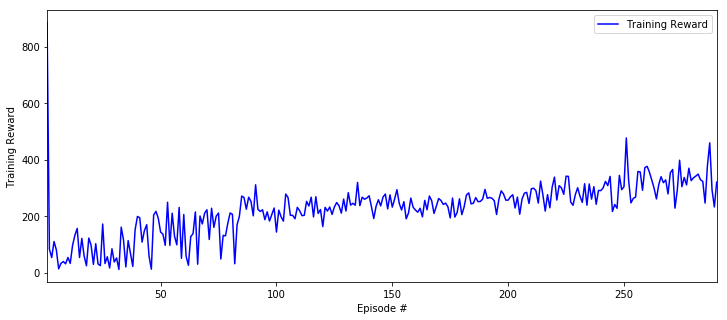

In [71]:
%matplotlib inline
import pandas as pd

csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = intermediate_folder_key + "/" + csv_file_name
wait_for_s3_object(s3_bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
df = df.dropna(subset=['Training Reward'])
x_axis = 'Episode #'
y_axis = 'Training Reward'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

### Clean up training resources

Running the following two code blocks will clean up the Amazon SageMaker training instance and the AWS RoboMaker simulation job. This should happen automatically if your training finished successfully, but if you want to terminate a training that's still running, run the code below.

In [72]:
for job_arn in job_arns:
    robomaker.cancel_simulation_job(job=job_arn)

In [73]:
sage_session.sagemaker_client.stop_training_job(TrainingJobName=estimator._current_job_name)

ClientError: An error occurred (ValidationException) when calling the StopTrainingJob operation: The request was rejected because the training job is in status Stopped.

At this point, a model has been trained and saved to the bucket defined in `s3_bucket` to a path of `s3_prefix`. Inside this folder in Amazon S3, you will find a few directories:

1. `environments` - Location of `deepracer_env.py` used in this simulation
2. `ip` - Status and IP address from simulator 
3. `model` - Model checkpoint files (you'll need these when retraining a model you've trained previously) 
4. `output` - A finished, packaged, and optimized model, which you could load on your AWS DeepRacer car 
5. `output/intermediate` - The CSV file of number of training rewards over the number of training episodes
5. `presets` - Location of `deepracer.py` used in this simulation  

## Evaluation

Evaluation jobs are deployed like training jobs. However, you do not need to deploy an Amazon SageMaker training instance to apply new learning to the working model. The point of an evaluation is to help you assess the model's behaviors in a controlled simulation.

Our evaluation is based on the number of successful laps around the track the car makes. `NUMBER_OF_TRIALS` is currently set to `20`, and will be running on `hard_track`. The length of time the car has to complete these `20` laps would be defined by `job_duration_in_seconds`. This value was defined for your training job, but if you'd like to decrease it, you can uncomment it below. 

In [75]:
envriron_vars = {"MODEL_S3_BUCKET": s3_bucket,
                 "MODEL_S3_PREFIX": s3_prefix,
                 "ROS_AWS_REGION": aws_region,
                 "NUMBER_OF_TRIALS": str(20),
                 "MARKOV_PRESET_FILE": "%s.py" % RLCOACH_PRESET,
                 "WORLD_NAME": "hard_track",
                 }

# Duration of evaluation job in seconds (1 hours)
# job_duration_in_seconds = 3600 * 1 

simulation_application = {"application":simulation_app_arn,
                          "launchConfig": {"packageName": "deepracer_simulation",
                                           "launchFile": "evaluation.launch",
                                           "environmentVariables": envriron_vars}
                         }
                            
vpcConfig = {"subnets": default_subnets,
             "securityGroups": default_security_groups,
             "assignPublicIp": True}

response =  robomaker.create_simulation_job(iamRole=role,
                                        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
                                        maxJobDurationInSeconds=job_duration_in_seconds,
                                        failureBehavior="Continue",
                                        simulationApplications=[simulation_application],
                                        vpcConfig=vpcConfig,
                                        outputLocation={"s3Bucket":s3_bucket, "s3Prefix":s3_prefix_robomaker}
                                        )
print("Created the following job:")
print("Job ARN", response["arn"])

Created the following job:
Job ARN arn:aws:robomaker:us-east-1:576690301298:simulation-job/sim-mrmt14fgz9xw


## Clean up simulation application resource

Your evaluation job may fail if your car cannot complete the defined number of successful trials. This could indicate that you need to do more training.

You can point this notebook to the model training checkpoint files, and refine your mode better as you get more familiar with these configurations and how the model performs under different conditions.

To clear the outputs of these code blocks, click **Kernel** on the Jupyter file bar and then select **Restart and Clear Output**'. This will reset all the variables defined during this run and clear the outputs, letting you start fresh again.

Running the code block below will ensure that the AWS RoboMaker evaluation simulation app has been shut down.



In [76]:
robomaker.delete_simulation_application(application=simulation_app_arn)

{'ResponseMetadata': {'RequestId': 'a0cc6adb-9672-11e9-8211-4d4341fd698b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 24 Jun 2019 11:24:28 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'a0cc6adb-9672-11e9-8211-4d4341fd698b',
   'x-amz-apigw-id': 'byDk3Ho4IAMFxlg=',
   'x-amzn-trace-id': 'Root=1-5d10b2eb-bd9a32763a9b0472f2b36b4c'},
  'RetryAttempts': 0}}

If you are going to be walking away from this exercise for a while, consider stopping this Amazon SageMaker instance. It's running on an ml.t3.xlarge. The AWS CloudFormation stack can be left, as the networking is part of the AWS free tier. Amazon S3 will bill on a price per GB per month for the data that is saved in `s3_bucket`. When you want to come back to this exercise, simply start this Amazon SageMaker instance and launch this Jupyter notebook again.

## Conclusion

Congratulations! You now have successfully:
1. Configured the appropriate environment and installed the right packages to utilize Amazon SageMaker
2. Used Amazon SageMaker to build, train, and evaluate a reinforcement learning model for AWS DeepRacer
3. Created, launched, and visualized a simulated environment in AWS RoboMaker|

## Add Model Artifacts to Team Tracker

add all artifacts to csv that can be used to determine the best model at a given time

this should be done after training/evaluation (above) and before commit

each row will be given unique id that must be used in Git commits and pushes to GitHub repo

commit the following files:

1. rl_deepracer_robomaker_coach.ipynb
2. deepracer_env.py
3. deepracer.py

In [71]:
tracker_s3_bucket = 'deepracer-tracker'
tracker_s3_key = 'deepracer-tracker.csv'

s3_tracker_url = 's3://{}/{}'.format(tracker_s3_bucket, tracker_s3_key)

# Convert CSV as DataFrame
df = pd.read_csv(s3_tracker_url, header=0, sep=',')
# list(df.columns)

# Make alterations to DataFrame
id = accountID + '-' + timestamp
modDf = df.append(pd.Series([id, s3_output_path], index=df.columns ), ignore_index=True)
# modDf.head()

# # Write CSV to S3 object
def _write_dataframe_to_csv_on_s3(dataframe, filename):
    """ Write a dataframe to a CSV on S3 """
    print("Writing {} record(s) to {}".format(len(dataframe), filename))
    # Create buffer
    csv_buffer = StringIO()
    # Write dataframe to buffer
    dataframe.to_csv(csv_buffer, sep=',', index=False)
    # Write buffer to S3 object
    s3.put_object(Body=csv_buffer.getvalue(), Bucket=tracker_s3_bucket, Key=tracker_s3_key)

_write_dataframe_to_csv_on_s3(modDf, tracker_s3_key)

Writing 11 record(s) to deepracer-tracker.csv
